# Basic Implementation of MINE

## Import libraries

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.autograd as autograd

## Set random seed

In [278]:
def set_rand_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_rand_seed(37)

## Gaussian generation
Independent with zero mean.

In [279]:
# mean
mean = [0, 0, 0]
# covariance matrix
cov = [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]
# sample number
sample_num = 1000
x = np.random.multivariate_normal(mean, cov, sample_num)

### True MI and two distributions

In [280]:
# Define the true mutual information for the Gaussian distribution
def theoretical_mi(cov):
    """
    Calculate the theoretical mutual information for a Gaussian distribution.
    Args:
        cov: Covariance matrix of the distribution.
    Returns:
        Theoretical mutual information value.
    """
    # Correlation coefficient (rho)
    rho = cov[0][1] / (np.sqrt(cov[0][0]) * np.sqrt(cov[1][1]))
    return -0.5 * np.log(1 - rho**2)

# Calculate the theoretical mutual information for the given covariance matrix
true_mi = theoretical_mi(cov)


# Generate joint and marginal samples
joint_data = x  # Joint distribution samples already generated
marginal_data = np.hstack([
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for X
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for Y
    np.random.normal(0, 1, size=(sample_num, 1))   # Independent samples for Z
])

### Visualization

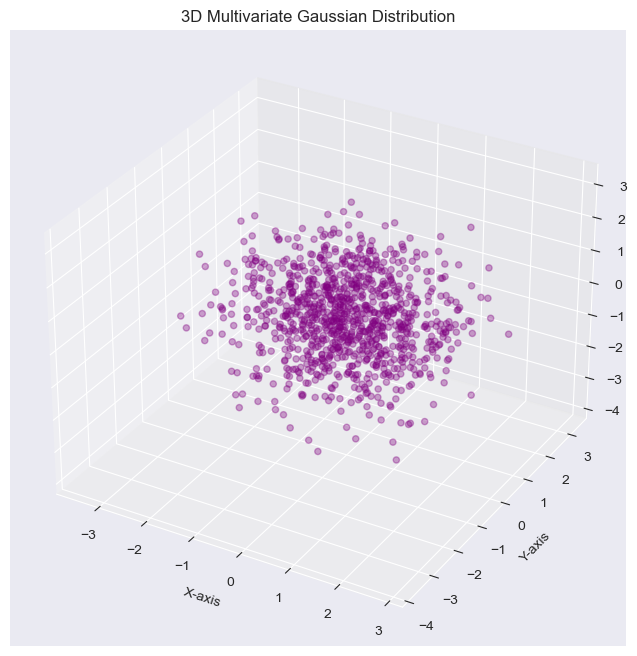

In [281]:
# Create a figure and a 3D axis for plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
ax.scatter(x[:, 0], x[:, 1], x[:, 2], alpha=0.35, c='purple')

# Set the title and axis labels
ax.set_title("3D Multivariate Gaussian Distribution")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

# Show the figure
plt.show()

## Define MINE and training

### Define network

In [282]:
class Mine(nn.Module):
    def __init__(self, input_size=3, hidden_size=128, output_size=1):
        """
        Mutual Information Neural Estimator (MINE)
        Args:
            input_size: The dimension of the input features (e.g., concatenated z and x).
            hidden_size: The number of units in the hidden layers.
        """
        super(Mine, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(hidden_size, output_size),
        )

        # Initialize the weights and biases of the layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)  # He initialization
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        """
        Forward pass through the MINE network
        Args:
            x: Input tensor of shape (batch_size, input_size)
        Returns:
            Tensor: Output scores of shape (batch_size, 1)
        """
        return self.network(x)

### Define training function
Original loss function:
$
\mathcal L = - \left( \mathbb{E}_{P(X, Z)}[t] - \log \mathbb{E}_{P(X)P(Z)}\left[e^{t}\right] \right)
$
Modified loss function:
$
\mathcal L = - \left( \mathbb{E}_{P(X, Z)}[t] - \frac{1}{\mathbb{E}[\text{ma(et)}]}\cdot \mathbb{E}_{P(X)P(Z)}\left[e^{t}\right] \right)
$

In [283]:
def mutual_information_estimate(t, et):
    """
    Estimate the mutual information using the MINE network.
    Args:
        t: Tensor of joint scores.
        et: Tensor of exp of marginal scores.
    Returns:
        Estimated mutual information.
    """
    return torch.mean(t) - torch.log(torch.mean(et))

def loss_function_original(t, et, _=None):
    """
    Compute the loss for MINE training.
    Args:
        t: Tensor of joint scores.
        et: Tensor of exp of marginal scores.
        _: Not used.
    Returns:
        Loss value.
    """
    return -mutual_information_estimate(t, et)

def loss_function_modified(t, et, ma_et):
    """
    Compute the loss for MINE training.
    Args:
        t: Tensor of joint scores.
        et: Tensor of exp of marginal scores.
        ma_et: Moving average of marginal scores.
    Returns:
        Loss value.
    """
    return -(torch.mean(t) - (1/ma_et.mean()).detach() * torch.mean(et))

def train_mine(joint_data, marginal_data, mine_net, optimizer, loss_func, batch_size, epochs):
    """
    Train the MINE network to estimate mutual information.

    Args:
        joint_data: Samples from the joint distribution P(X, Z).
        marginal_data: Samples from the marginal distribution P(X)P(Z).
        mine_net: MINE network to be trained.
        optimizer: Optimizer for MINE network.
        loss_func: Loss function.
        batch_size: Number of samples per batch.
        epochs: Number of training epochs.

    Returns:
        List of mutual information estimates during training.
    """
    ma_et = 1.0  # Moving average for stability
    ma_rate = 0.01  # Rate for moving average update
    results:list = []

    for epoch in range(epochs):
        # Sample a batch from joint and marginal distributions
        joint_batch = torch.tensor(joint_data[np.random.choice(joint_data.shape[0], batch_size, replace=False)], dtype=torch.float32)
        marginal_batch = torch.tensor(marginal_data[np.random.choice(marginal_data.shape[0], batch_size, replace=False)], dtype=torch.float32)

        # Compute MINE outputs
        t = mine_net(joint_batch)
        et = torch.exp(mine_net(marginal_batch))
        ma_et = (1 - ma_rate) * ma_et + ma_rate * torch.mean(et)    # Update moving average

        # Compute mutual information lower bound
        loss = loss_func(t, et, ma_et.detach())

        # Backpropagation and optimization
        optimizer.zero_grad()
        autograd.backward(loss)
        optimizer.step()

        # Log mutual information estimate
        mi_estimate = mutual_information_estimate(t, et)
        results.append(mi_estimate.item())

        """
        if (epoch + 1) % log_freq == 0:
            print(f"Epoch {epoch + 1}/{epochs}, MI Estimate: {mi_estimate.item()}")
        """

    return results

def train_and_visualize(input_size, joint_data, marginal_data, true_mi, batch_size, epochs, lr, loss_func):
    """
    Train MINE network and visualize the estimated mutual information.

    Args:
        input_size: Dimension of the input data (e.g., 2 for 2D Gaussian, 3 for 3D Gaussian).
        joint_data: Samples from the joint distribution P(X, Z).
        marginal_data: Samples from the marginal distribution P(X)P(Z).
        true_mi: Theoretical mutual information value for comparison.
        batch_size: Number of samples per batch.
        epochs: Number of training epochs.
        lr: Learning rate for the optimizer.
        loss_func: Loss function for training MINE (original or modified).

    Returns:
        None: The function generates a plot comparing the estimated MI with the theoretical MI.
    """
    mine_net = Mine(input_size, hidden_size=128, output_size=1)  # Match input size to 3 (x, y, z)
    optimizer = torch.optim.Adam(mine_net.parameters(), lr=lr)

    mi_estimates = train_mine(joint_data,
                              marginal_data,
                              mine_net,
                              optimizer,
                              loss_func=loss_func,
                              batch_size=batch_size,
                              epochs=epochs)

    # visualization
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(mi_estimates)), mi_estimates, label="Estimated MI")
    plt.axhline(y=true_mi, color="r", linestyle="--", label="True MI (Theoretical)")
    plt.xlabel("Epochs")
    plt.ylabel("Mutual Information")
    plt.title("Mutual Information Estimation vs. True Value")
    plt.legend()
    plt.grid(True)
    plt.show()

### Training

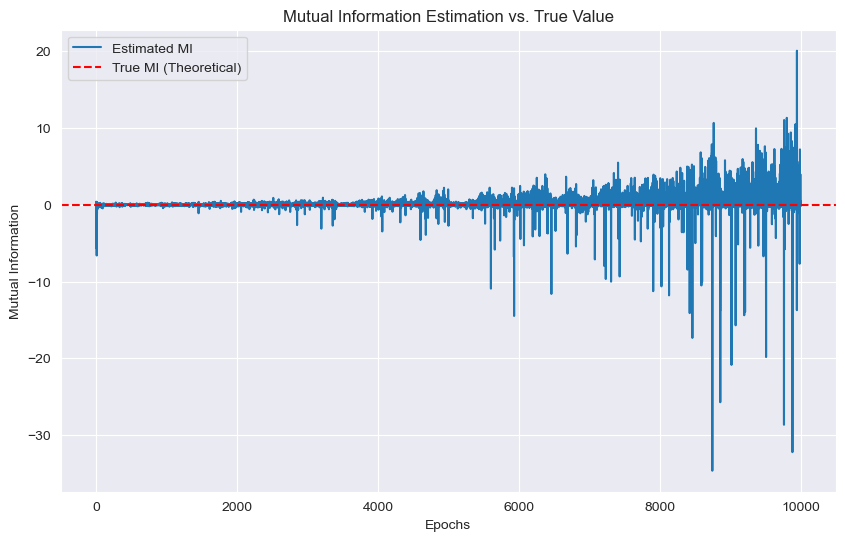

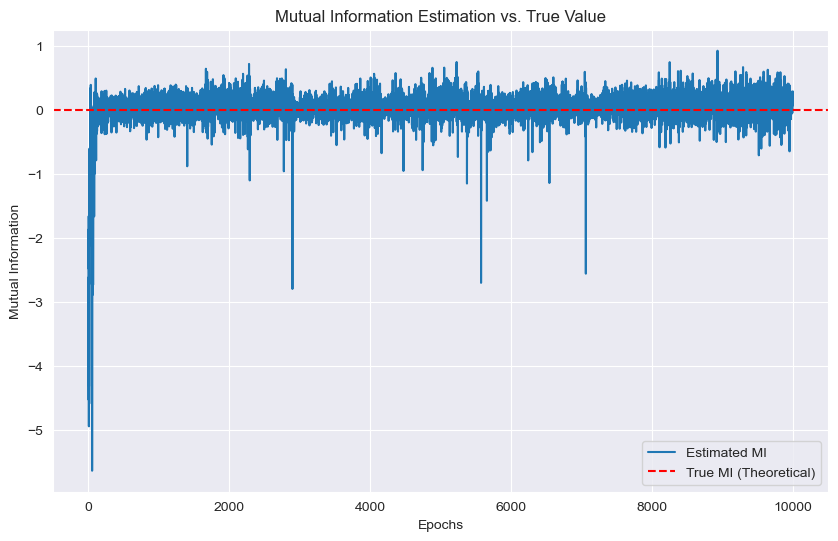

In [284]:
lr = 1e-2
batch_size = 16
epochs = 10000

train_and_visualize(3,
                    joint_data,
                    marginal_data,
                    true_mi,
                    batch_size,
                    epochs,
                    lr,
                    loss_func = loss_function_original)

train_and_visualize(3,
                    joint_data,
                    marginal_data,
                    true_mi,
                    batch_size,
                    epochs,
                    lr,
                    loss_func = loss_function_modified)

## Extra experiment on 4-D Gaussian

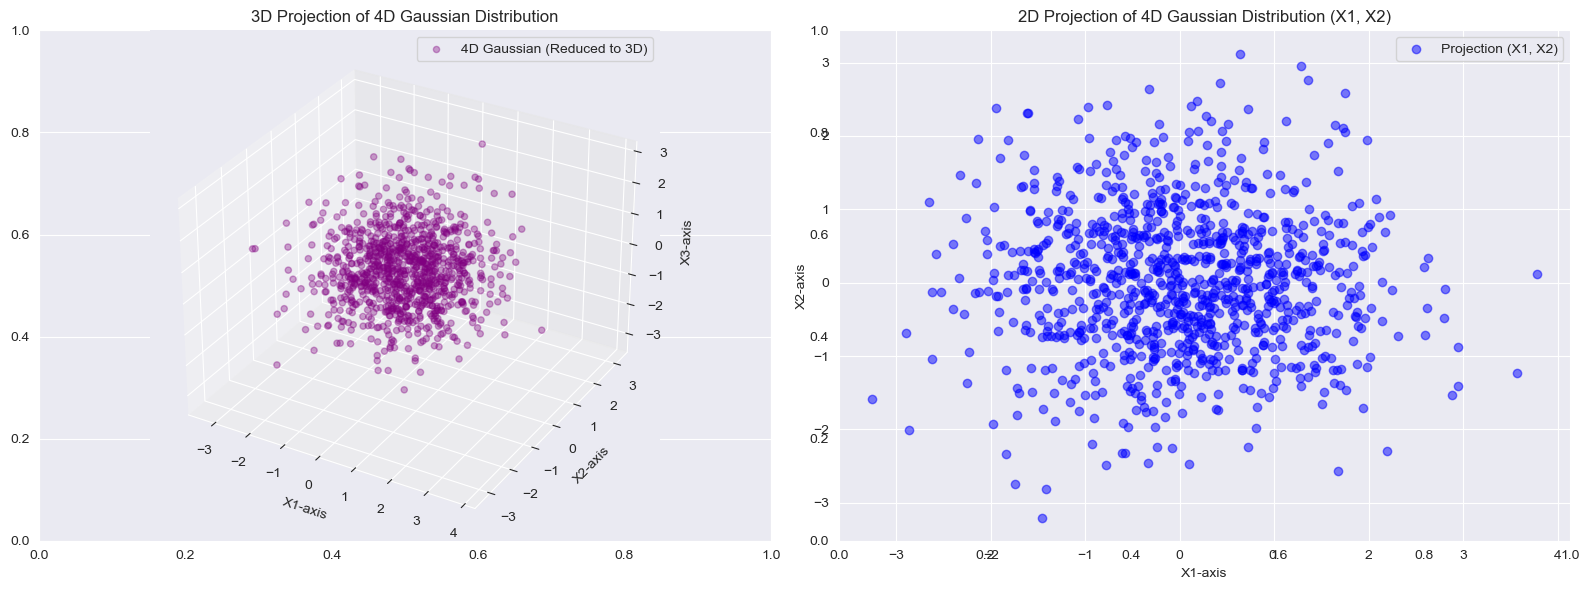

In [287]:
# Define mean and covariance matrix for 2D Gaussian distribution
mean_4d = [0, 0, 0, 0]  # Mean for 2D Gaussian
cov_4d = [[1, 0, 0, 0],  # Covariance matrix for 4D Gaussian
          [0, 1, 0, 0],
          [0, 0, 1, 0],
          [0, 0, 0, 1]]
# Sample numbers
sample_num = 1000

# Generate samples for 2D and 3D Gaussians
x_4d = np.random.multivariate_normal(mean_4d, cov_4d, sample_num)

# Calculate the theoretical mutual information for the given covariance matrix
true_mi_4d = theoretical_mi(cov_4d)

# Generate joint and marginal samples
joint_data_4d = x_4d  # Joint distribution samples already generated
marginal_data_4d = np.hstack([
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for X1
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for X2
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for X3
    np.random.normal(0, 1, size=(sample_num, 1)),  # Independent samples for X4
])

# visualization: Reduce to 3D for plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: 3D scatter plot (reduced from 4D Gaussian)
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(x_4d[:, 0], x_4d[:, 1], x_4d[:, 2], alpha=0.35, c='purple', label="4D Gaussian (Reduced to 3D)")
ax1.set_title("3D Projection of 4D Gaussian Distribution")
ax1.set_xlabel("X1-axis")
ax1.set_ylabel("X2-axis")
ax1.set_zlabel("X3-axis")
ax1.legend()

# Right subplot: 2D scatter plot (X1 vs. X2)
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(x_4d[:, 0], x_4d[:, 1], alpha=0.5, c='blue', label="Projection (X1, X2)")
ax2.set_title("2D Projection of 4D Gaussian Distribution (X1, X2)")
ax2.set_xlabel("X1-axis")
ax2.set_ylabel("X2-axis")
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### MI estimation using MINE

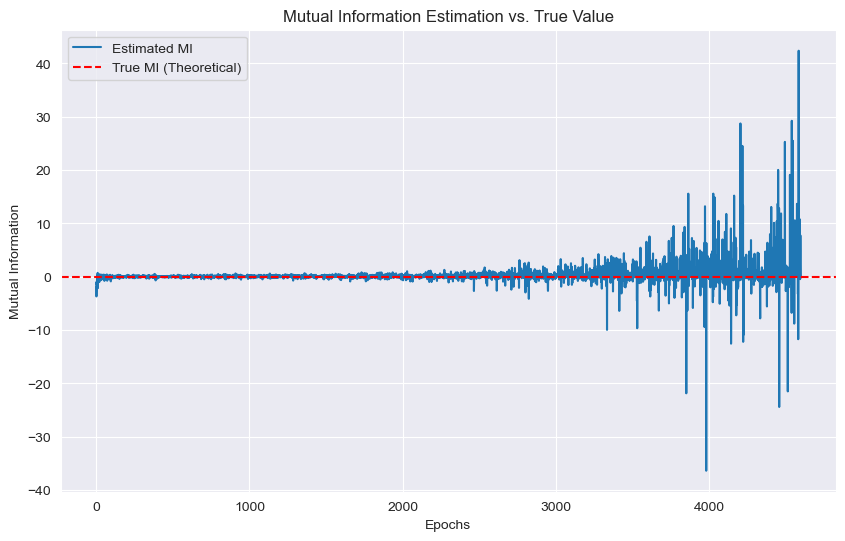

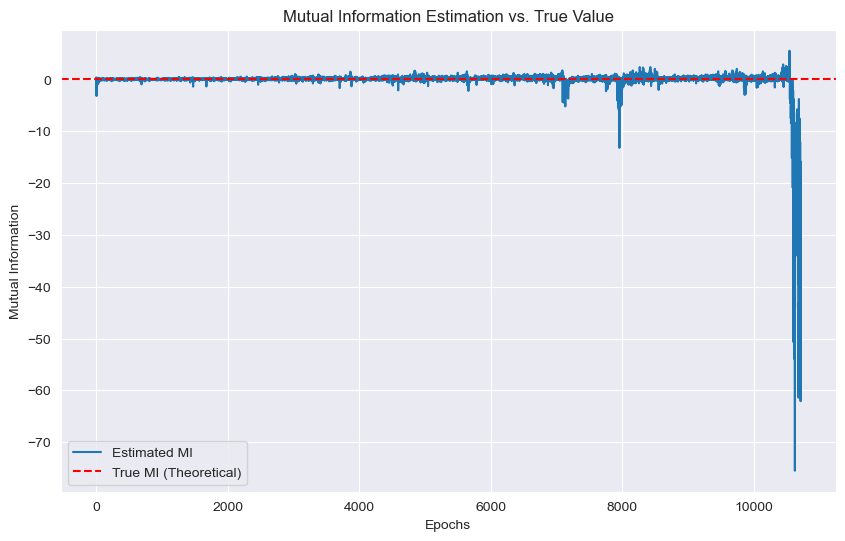

In [292]:
lr = 1e-2
batch_size = 16
epochs = 50000

train_and_visualize(4,
                    joint_data_4d,
                    marginal_data_4d,
                    true_mi_4d,
                    batch_size,
                    epochs,
                    lr,
                    loss_func = loss_function_original)

train_and_visualize(4,
                    joint_data_4d,
                    marginal_data_4d,
                    true_mi_4d,
                    batch_size,
                    epochs,
                    lr,
                    loss_func = loss_function_modified)